# Instalando as libs do kaggle e minisom

In [1]:
!pip install minisom 
!pip install scikit-learn
!pip install --upgrade kaggle

  Created wheel for minisom: filename=MiniSom-2.2.8-cp37-none-any.whl size=8604 sha256=e052c6c8996f4020fb2616b26c7c447b4c4d5352390b13b533c1d784f2c7184d
  Stored in directory: /root/.cache/pip/wheels/78/7e/a8/435947263149d3b94fa65339751f8c65617c436b0bdfb29c7d
Successfully built minisom
     |████████████████████████████████| 61kB 2.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=55f94c0d6b1d195e942b4f76d98bb4532724e3568e7df98a4929991ac83b2c71
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


# upload da chave da API




In [2]:
#OBS: o arquivo kaggle.json precisa ser baixado da sua conta pessoal do Kaggle.
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn]))
    )

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


# Movendo arquivo da API para pasta de configuração

- Ele deve ficar na pasta ```~/.kaggle```
- Depois disso mudar as permissões para "leitura e escrita" (2 + 4 = 6)

> Bloco com recuo



In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Download do dataset


In [4]:
#!kaggle datasets download -d /spotify-dataset-yamaerenay19212020-160k-tracks
#!unzip spotify-dataset-19212020-160k-tracks.zip -d destination_folder
!kaggle datasets download -d teejmahal20/airline-passenger-satisfaction
!unzip airline-passenger-satisfaction.zip -d destination_folder

  0% 0.00/2.71M [00:00<?, ?B/s]
100% 2.71M/2.71M [00:00<00:00, 86.3MB/s]
Archive:  airline-passenger-satisfaction.zip
  inflating: destination_folder/test.csv  
  inflating: destination_folder/train.csv  


In [ ]:
!ls destination_folder

In [5]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from minisom import MiniSom
import scipy.cluster.hierarchy as shc       # para usar o dendrograma
%matplotlib inline

In [71]:
data = pd.read_csv(r'destination_folder/train.csv')
data_test = pd.read_csv(r'destination_folder/test.csv')

data.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)
data = pd.concat([data, data_test])         # concatenar os dois conjuntos, já que é um problema de clustering
data = data.drop(['Unnamed: 0', 'id'], axis=1)   # retirar as colunas de informações irrelevantes ao problema

#data = data.drop(['artists', 'id', 'name', 'mode', 'explicit', 'release_date', 'year', 'key'], 1)
#data = data.astype({'duration_ms': 'float64', 'popularity': 'float64'}, copy=False)
data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [72]:
data.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


# Pré-processando os dados categóricos

In [73]:
# separando as colunas que passarao por tratamentos especiais
nominal_data = data[['Gender', 'Customer Type', 'Type of Travel']]
ordinal_data = data[['Class', 'satisfaction']]    # Eco < Eco Plus < Business (em termos de relevância ou preço) 
                                                # neutral or dissatisfied < satisfied
# removendo as colunas que na sequência passarão pelo encoding
data = data.drop(columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction'])

In [74]:
# tratando os dados ordinais: ['Class']
class_labels = ['Eco', 'Eco Plus', 'Business']
ordinal_data['Class'] = ordinal_data['Class'].astype(CategoricalDtype(categories=class_labels, ordered=True))
ordinal_data['Class'] = ordinal_data['Class'].cat.codes

satisfied_labels = ['neutral or dissatisfied', 'satisfied']
ordinal_data['satisfaction'] = ordinal_data['satisfaction'].astype(CategoricalDtype(categories=satisfied_labels, ordered=True))
ordinal_data['satisfaction'] = ordinal_data['satisfaction'].cat.codes


data['Class'] = ordinal_data['Class']
data['satisfaction'] = ordinal_data['satisfaction']

In [75]:
# tratando os dados nominais: ['Gender', 'Customer Type', 'Type of Travel', 'satisfaction']
for column in nominal_data:
    encoded_data = pd.get_dummies(nominal_data[column])
    data = pd.concat([data, encoded_data], axis=1)

In [76]:
data.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Class,satisfaction,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel
0,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,1,0,0,1,1,0,0,1
1,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,2,0,0,1,0,1,1,0
2,26,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,2,1,1,0,1,0,1,0
3,25,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,2,0,1,0,1,0,1,0
4,61,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,2,1,0,1,1,0,1,0


# Normalizando os dados

In [77]:
# removendo as linhas que contêm NaN
# como são poucas, não é inviável
data = data.dropna()
columns = data.columns

feature_names = list(data.columns)

target = data['satisfaction'].values   # classes em questão
label_names = {0: 'neutral or dissatisfied', 1: 'satisfied'}

In [78]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data) # normaliza/escala e converte para array numpy que é o que o MiniSom() aceita
num_features = data.shape[1]    # numero de colunas/features

# Treinando o modelo

In [92]:
grid_size = 30
som = MiniSom(x=grid_size, 
              y=grid_size,
              input_len=num_features,
              sigma=1.0,
              learning_rate=0.5,
              neighborhood_function='gaussian',
              activation_distance='euclidean')
som.pca_weights_init(data)
som.train_random(data, 200000, verbose=True)

 [ 200000 / 200000 ] 100% - 0:00:00 left 
 quantization error: 0.5858289312491579


# Visualização dos resultados

Mapa de componentes (regiões mais quentes, i.e., tendendo ao vermelho têm distâncias entre os neurônios maiores)

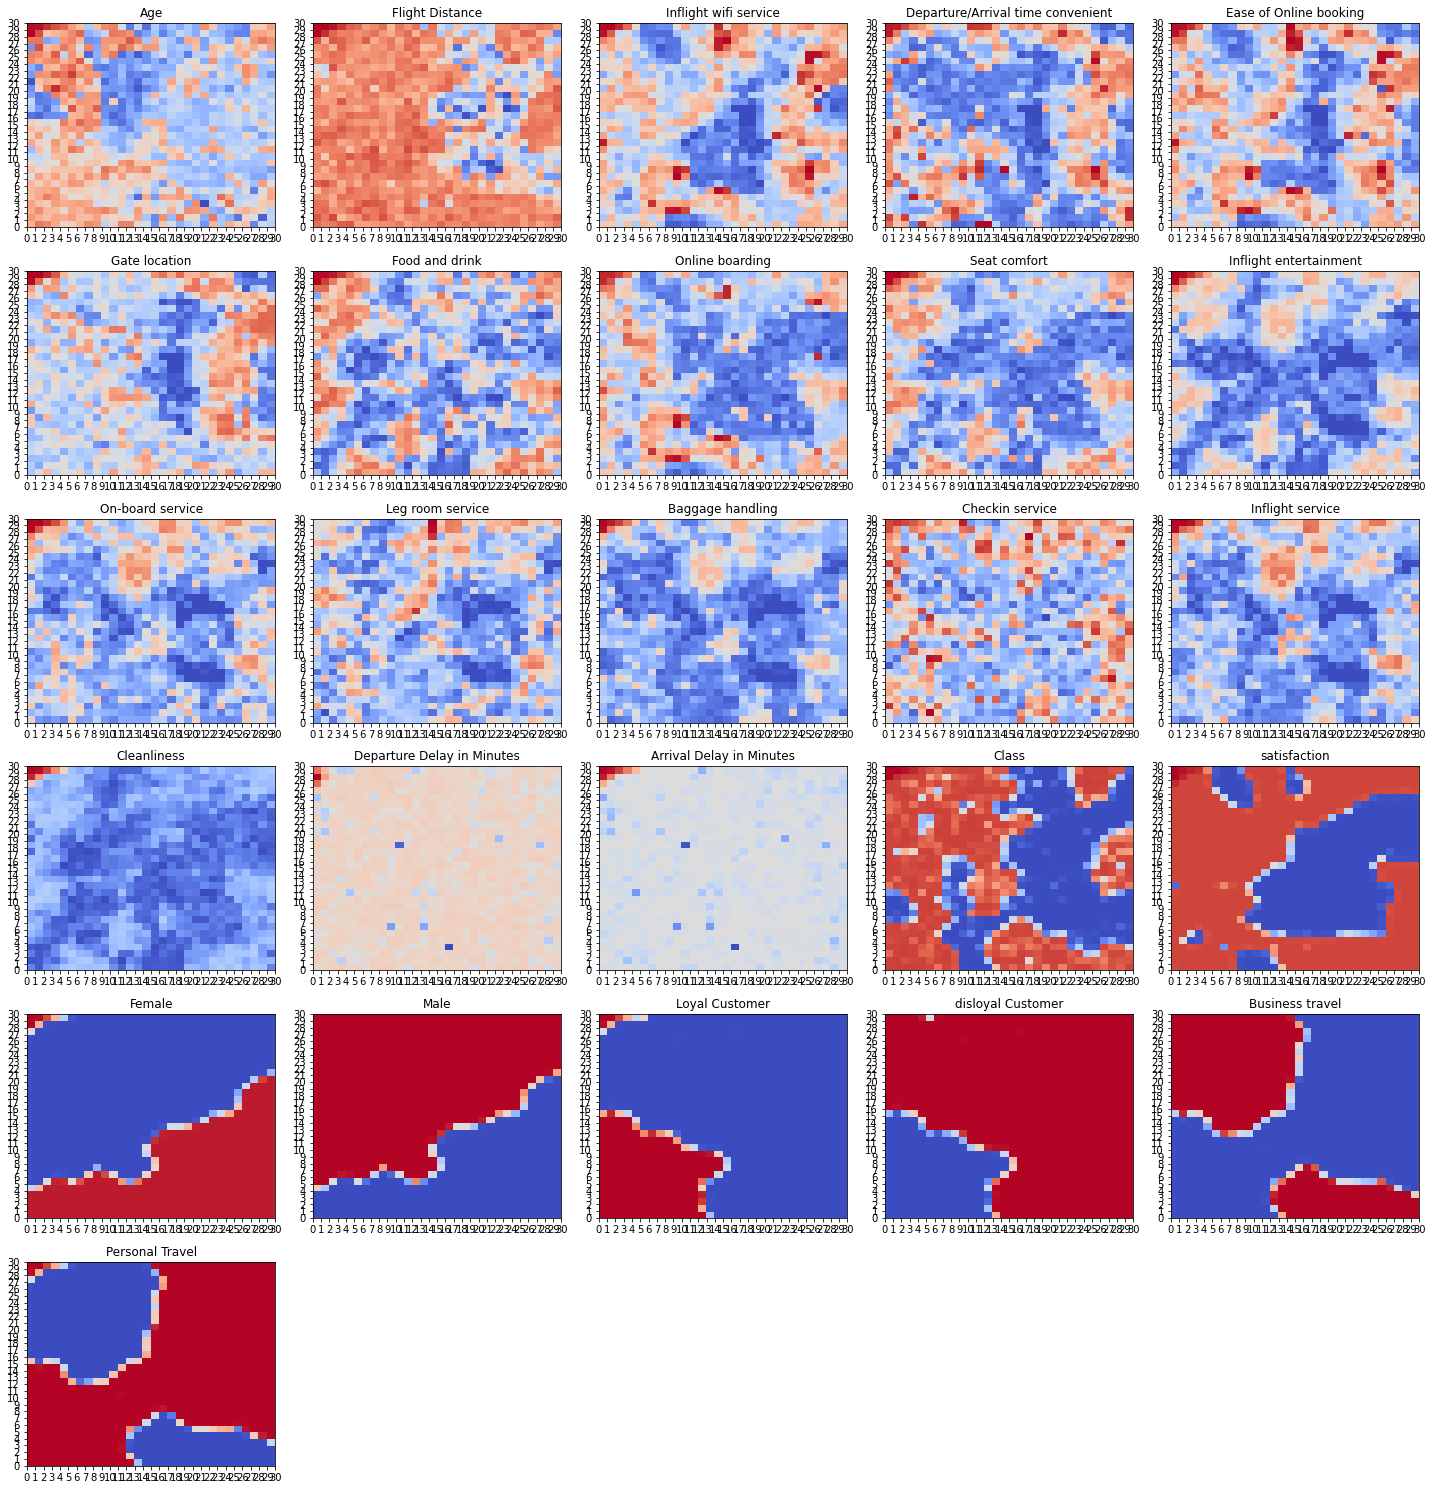

In [96]:
trained_weights = som.get_weights()     # n x m x num_features = 10 x 10 x 26
plt.figure(figsize=(20, 24))

for i, f in enumerate(feature_names):
    plt.subplot(7, 5, i+1)
    plt.title(f)
    plt.pcolor(trained_weights[:,:,i].T, cmap='coolwarm_r')
    plt.xticks(np.arange(grid_size+1))
    plt.yticks(np.arange(grid_size+1))

plt.tight_layout()
plt.show()

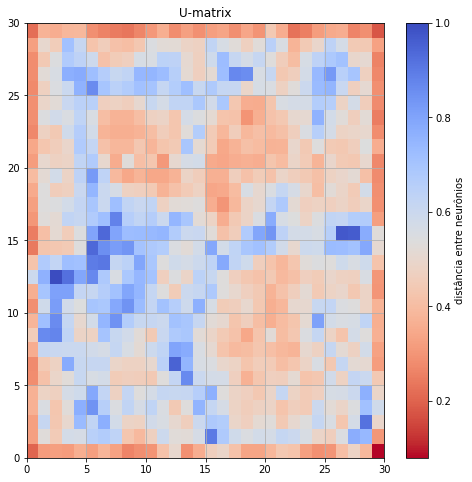

In [97]:
# visualização do grid
plt.figure(1, figsize=(8, 8), frameon=False)
plt.bone()

plt.title('U-matrix')
plt.pcolor(som.distance_map(), cmap='coolwarm_r')# average dist. to neighs.
plt.colorbar(label='distância entre neurônios')
plt.grid()
plt.show()

"When dealing with a supervised problem, one can visualize the proportion of samples per class falling in a specific neuron using a pie chart per neuron"

Basicamente, o que segue é uma visualização das porções das samples utilizadas de uma forma que pertença à determinada classe (representada pelos neurônios em forma de gráfico de pizza).

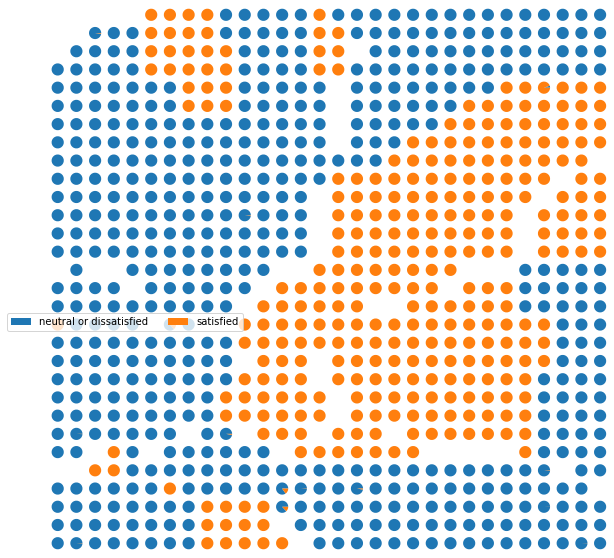

In [98]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(10, 10))
the_grid = gridspec.GridSpec(grid_size, grid_size, fig)

for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[grid_size-1-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(-3, 10), ncol=3)
plt.show()

### Aqui será visualizado no grid uma porção de pontos, cada um representando o neurônio vencedor. 

*OBS*: Da referência, tem-se que "To have an overview of how the samples are distributed across the map a scatter chart can be used where each dot represents the coordinates of the winning neuron. A random offset is added to avoid overlaps between points within the same cell."

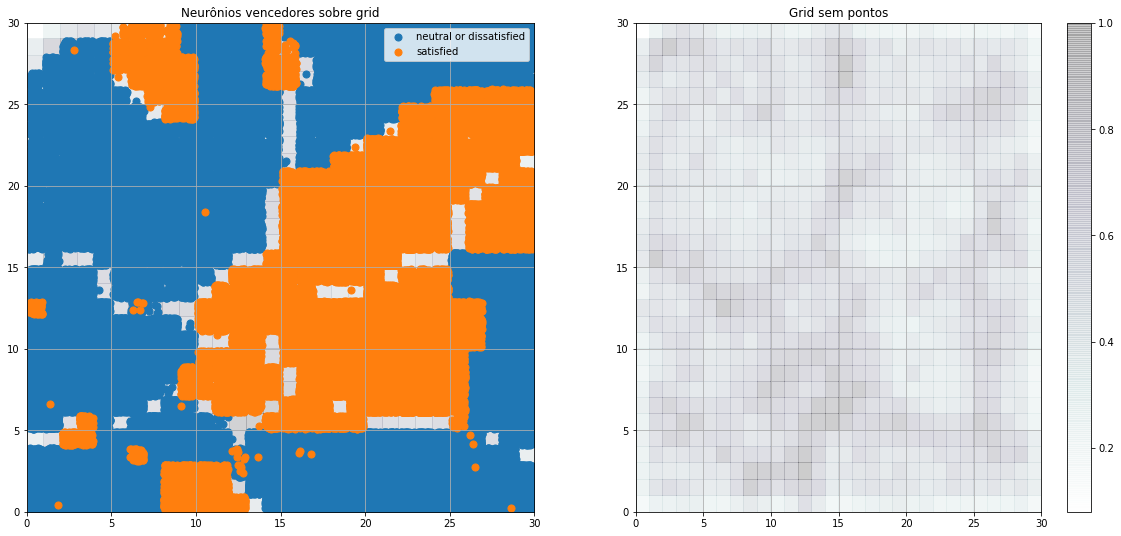

In [99]:
# cores diferentes para cada classe
colors = ['C1', 'C0']

w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(20, 9))

plt.subplot(1, 2, 1)
plt.title('Neurônios vencedores sobre grid')
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Grid sem pontos')
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()
plt.grid()

plt.show()

# REFERÊNCIAS

A principal fonte de referências, principalmente quanto às formas de visualização dos modelos criados com a biblioteca MiniSom podem ser encontradas nos exemplos contidos no repositório da biblioteca:

- https://github.com/JustGlowing/minisom
- https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction?select=train.csv (base de dados)